In [286]:
import pandas as pd
import matplotlib.pyplot as plt

In [287]:
puntajes = pd.read_csv("../A_INSCRITOS_PUNTAJES_2023_PAES_PUB_MRUN.csv", sep=";")
puntajes.head()

C:\Users\mmira\AppData\Local\Temp\ipykernel_8188\730207773.py:1: DtypeWarning: Columns (17,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  puntajes = pd.read_csv("../A_INSCRITOS_PUNTAJES_2023_PAES_PUB_MRUN.csv", sep=";")


,MRUN,ANYO_PROCESO,COD_SEXO,FECHA_NACIMIENTO,RBD,CODIGO_ENS,LOCAL_EDUCACIONAL,UNIDAD_EDUCATIVA,NOMBRE_UNIDAD_EDUC,RAMA_EDUCACIONAL,...,PRUEBA_INV_CQUI,FORMA_INV_CQUI,CORRECTAS_INV_CQUI,ERRADAS_INV_CQUI,OMITIDAS_INV_CQUI,PRUEBA_INV_CTP,FORMA_INV_CTP,CORRECTAS_INV_CTP,ERRADAS_INV_CTP,OMITIDAS_INV_CTP
0,3703667,2023,1,194708,5654,310,1747,1,INSTITUTO CLARET,H1,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
1,8437289,2023,1,194503,40407,363,3997,1,CENTRO DE ESTUDIOS BORDEMAR,H2,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
2,17372901,2023,1,194612,3645,363,1514,1,LICEO VIDA NUEVA,H2,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
3,16702090,2023,2,200308,109,610,25,4,COLEGIO DEPORTIVO TEC. PROF. ELENA DUVAUCHELLE...,T3,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0
4,22654139,2023,2,194507,3003,363,1450,2,COLEGIO PIAGET,H2,...,Ciencias Química.,0,0,0,0,Ciencias Técnico Profesional.,0,0,0,0


In [288]:
socioeconomic = pd.read_csv("../B_SOCIOECONOMICO_DOMICILIO_2023_PAES_PUB_MRUN.csv", sep=";")
socioeconomic.head()

,MRUN,ANYO_PROCESO,CODIGO_REGION_DOMICILIO,CODIGO_PROVINCIA_DOMICILIO,CODIGO_COMUNA_DOMICILIO,NOMBRE_COMUNA_DOMICILIO,SEXO,FECHA_NACIMIENTO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,...,USO_ESPACIO_1,USO_ESPACIO_2,USO_ESPACIO_3,USO_ESPACIO_4,USO_ESPACIO_5,USO_ESPACIO_6,USO_ESPACIO_7,USO_ESPACIO_8,TRANQUILIDAD_COLEGIO,TRABAJO_GRUPO_COLEGIO
0,3703667,2023,9,91,9101,TEMUCO,1,194708,8,1,...,0,0,0,0,0,0,0,0,9,9
1,8437289,2023,5,55,5506,NOGALES,1,194503,6,2,...,0,2,0,0,0,0,0,0,4,4
2,17372901,2023,16,161,16101,CHILLAN,1,194612,5,6,...,0,0,0,0,0,0,2,2,1,1
3,16702090,2023,1,11,1101,IQUIQUE,2,200308,3,2,...,0,2,0,0,0,0,0,1,2,5
4,22654139,2023,7,71,7105,MAULE,2,194507,5,5,...,0,0,0,0,0,0,0,0,9,9


In [289]:
new_1 = socioeconomic.drop(['FECHA_NACIMIENTO','ANYO_PROCESO', 'CODIGO_REGION_DOMICILIO','CODIGO_PROVINCIA_DOMICILIO','CODIGO_COMUNA_DOMICILIO','NOMBRE_COMUNA_DOMICILIO'], axis=1)
#quite ciertos datos de socioeconomic que no ibamos a usar :p

In [290]:
columnas_puntajes = ['MRUN', 'DEPENDENCIA', 'PROMEDIO_NOTAS','PTJE_NEM','PTJE_RANKING','CLEC_REG_ACTUAL','MATE1_REG_ACTUAL','MATE2_REG_ACTUAL','HCSOC_REG_ACTUAL','CIEN_REG_ACTUAL','PROMEDIO_CM_MAX','CLEC_MAX','MATE1_MAX','MATE2_MAX','HCSOC_MAX','CIEN_MAX']
new_2 = puntajes[columnas_puntajes]
#quite unos datos de puntajes tambien

In [291]:
#merge entre new_1 y new_2
merged_new = pd.merge(new_1,new_2,on='MRUN')
merged_new

,MRUN,SEXO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,DISPOSITIVO_1,DISPOSITIVO_2,DISPOSITIVO_3,DISPOSITIVO_4,DISPOSITIVO_5,USO_DISPOSITIVO_1,...,MATE1_REG_ACTUAL,MATE2_REG_ACTUAL,HCSOC_REG_ACTUAL,CIEN_REG_ACTUAL,PROMEDIO_CM_MAX,CLEC_MAX,MATE1_MAX,MATE2_MAX,HCSOC_MAX,CIEN_MAX
0,3703667,1,8,1,S,N,S,N,N,3,...,846,558,836,748,831,816,846,728,950,748
1,8437289,1,6,2,N,N,S,N,N,0,...,0,0,0,0,0,0,0,0,0,0
2,17372901,1,5,6,N,N,N,S,N,0,...,499,0,0,412,"498,5",498,499,0,0,412
3,16702090,2,3,2,N,N,S,N,N,0,...,0,0,0,0,0,0,0,0,0,0
4,22654139,2,5,5,N,N,N,N,S,0,...,402,413,318,0,383,364,402,413,318,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296807,26526755,1,1,3,N,N,S,N,N,0,...,757,483,0,578,695,633,757,483,0,578
296808,26526694,1,2,3,S,N,S,N,N,2,...,516,313,0,498,"638,5",761,516,386,0,498
296809,26526332,1,1,3,N,N,S,N,N,0,...,480,332,578,500,531,582,480,403,578,500
296810,26525532,1,3,3,S,S,S,N,N,1,...,579,292,565,519,"592,5",606,579,292,565,519


Aquí empieza la limpieza de datos de las columnas de merged_new

In [292]:
tipos_dato = merged_new.dtypes 
print(tipos_dato)

MRUN                           int64
SEXO                           int64
INGRESO_PERCAPITA_GRUPO_FA     int64
RAZON_PRINCIPAL_PAES           int64
DISPOSITIVO_1                 object
DISPOSITIVO_2                 object
DISPOSITIVO_3                 object
DISPOSITIVO_4                 object
DISPOSITIVO_5                 object
USO_DISPOSITIVO_1              int64
USO_DISPOSITIVO_2              int64
USO_DISPOSITIVO_3              int64
HOGAR_CONEXION_INTERNET       object
CONEXION_INSUFICIENTE          int64
ESPACIO_1                     object
ESPACIO_2                     object
ESPACIO_3                     object
ESPACIO_4                     object
ESPACIO_5                     object
ESPACIO_6                     object
ESPACIO_7                     object
ESPACIO_8                     object
ESPACIO_9                     object
USO_ESPACIO_1                  int64
USO_ESPACIO_2                  int64
USO_ESPACIO_3                  int64
USO_ESPACIO_4                  int64
U

In [293]:
import numpy as np

#cambiar las comas por puntos
merged_new['PROMEDIO_CM_MAX'] = merged_new['PROMEDIO_CM_MAX'].str.replace(',', '.').astype(float)
merged_new['PROMEDIO_NOTAS'] = merged_new['PROMEDIO_NOTAS'].str.replace(',', '.').astype(float)

#para todas las columnas que poseen N o S se cambia por 0 o 1
cols = ['DISPOSITIVO_1', 'DISPOSITIVO_2', 'DISPOSITIVO_3', 'DISPOSITIVO_4', 'DISPOSITIVO_5', 'HOGAR_CONEXION_INTERNET', 'ESPACIO_1', 'ESPACIO_2', 'ESPACIO_3', 'ESPACIO_4', 'ESPACIO_5', 'ESPACIO_6', 'ESPACIO_7', 'ESPACIO_8', 'ESPACIO_9']

# Valores distintos a 'N' o 'S' se reemplazan por NaN
for col in cols:
    merged_new[col] = merged_new[col].apply(lambda x: x if x in ['N', 'S'] else np.nan)

# Eliminar los NaN
merged_new.dropna(subset=cols, inplace=True)

# Transformación de tipo
for col in cols:
    merged_new[col] = merged_new[col].str.replace('N', '0').str.replace('S', '1').astype(int)
    print(f"Columna transformada: {col}")

print("\nDataFrame después de la transformación:")
print(merged_new)

Columna transformada: DISPOSITIVO_1
Columna transformada: DISPOSITIVO_2
Columna transformada: DISPOSITIVO_3
Columna transformada: DISPOSITIVO_4
Columna transformada: DISPOSITIVO_5
Columna transformada: HOGAR_CONEXION_INTERNET
Columna transformada: ESPACIO_1
Columna transformada: ESPACIO_2
Columna transformada: ESPACIO_3
Columna transformada: ESPACIO_4
Columna transformada: ESPACIO_5
Columna transformada: ESPACIO_6
Columna transformada: ESPACIO_7
Columna transformada: ESPACIO_8
Columna transformada: ESPACIO_9

DataFrame después de la transformación:
            MRUN  SEXO  INGRESO_PERCAPITA_GRUPO_FA  RAZON_PRINCIPAL_PAES  \
0        3703667     1                           8                     1   
1        8437289     1                           6                     2   
2       17372901     1                           5                     6   
3       16702090     2                           3                     2   
4       22654139     2                           5               

In [294]:
#para los datos Nan que son discretos se cambian a 0, quizas despues puede ser el promedio 
antes = merged_new.shape[0]
for col in merged_new.select_dtypes(include=['object']).columns:
    # merged_new[col] = merged_new[col].replace(' ', '0')
    # merged_new[col] = merged_new[col].astype(int)
    merged_new[col] = pd.to_numeric(merged_new[col], errors='coerce')
    merged_new = merged_new.dropna(subset=[col])
    print(f"Columna transformada: {col}")

print("Filas antes:")
print(antes)
print("Filas eliminadas:")
print(antes-merged_new.shape[0])

Columna transformada: DEPENDENCIA
Columna transformada: CLEC_REG_ACTUAL


C:\Users\mmira\AppData\Local\Temp\ipykernel_8188\3175640318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_new[col] = pd.to_numeric(merged_new[col], errors='coerce')


Columna transformada: MATE1_REG_ACTUAL
Columna transformada: MATE2_REG_ACTUAL
Columna transformada: HCSOC_REG_ACTUAL
Columna transformada: CIEN_REG_ACTUAL
Filas antes:
285734
Filas eliminadas:
23077


Clusters con KMeans

In [295]:
#seleccion de columnas para hacer el cluster 
# data1 = merged_new[['PROMEDIO_CM_MAX','RAZON_PRINCIPAL_PAES','USO_DISPOSITIVO_1','USO_DISPOSITIVO_2','USO_DISPOSITIVO_3','CONEXION_INSUFICIENTE','USO_ESPACIO_1','USO_ESPACIO_2','USO_ESPACIO_3','USO_ESPACIO_4','USO_ESPACIO_5','USO_ESPACIO_6','USO_ESPACIO_7','USO_ESPACIO_8','TRANQUILIDAD_COLEGIO','TRABAJO_GRUPO_COLEGIO']]
data1 = merged_new[['PROMEDIO_CM_MAX', 'INGRESO_PERCAPITA_GRUPO_FA','RAZON_PRINCIPAL_PAES','USO_DISPOSITIVO_1','USO_DISPOSITIVO_2','USO_DISPOSITIVO_3','CONEXION_INSUFICIENTE','USO_ESPACIO_1','USO_ESPACIO_2','USO_ESPACIO_3','USO_ESPACIO_4','USO_ESPACIO_5','USO_ESPACIO_6','USO_ESPACIO_7','USO_ESPACIO_8','TRANQUILIDAD_COLEGIO','TRABAJO_GRUPO_COLEGIO']]
idxs = [1, 4, 7, 13]
data = data1[(data1['RAZON_PRINCIPAL_PAES'].isin([1,2,3,4,5,6,8]))& (data1['PROMEDIO_CM_MAX']>=200)]
data

,PROMEDIO_CM_MAX,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,USO_DISPOSITIVO_1,USO_DISPOSITIVO_2,USO_DISPOSITIVO_3,CONEXION_INSUFICIENTE,USO_ESPACIO_1,USO_ESPACIO_2,USO_ESPACIO_3,USO_ESPACIO_4,USO_ESPACIO_5,USO_ESPACIO_6,USO_ESPACIO_7,USO_ESPACIO_8,TRANQUILIDAD_COLEGIO,TRABAJO_GRUPO_COLEGIO
0,831.0,8,1,3,0,3,1,0,0,0,0,0,0,0,0,9,9
2,498.5,5,6,0,0,0,9,0,0,0,0,0,0,2,2,1,1
4,383.0,5,5,0,0,0,2,0,0,0,0,0,0,0,0,9,9
7,674.0,5,1,2,0,2,2,2,4,2,0,0,2,2,0,5,5
10,429.0,8,2,0,0,2,3,2,0,0,0,0,0,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296807,695.0,1,3,0,0,2,9,0,0,0,0,0,0,1,0,5,4
296808,638.5,2,3,2,0,3,3,1,2,0,0,0,0,1,1,2,5
296809,531.0,1,3,0,0,4,2,0,0,0,0,0,0,0,0,9,2
296810,592.5,3,3,1,1,2,2,1,1,2,1,0,3,1,2,5,2


In [296]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, f_regression

#se normalizan los datos
normalizer = Normalizer()
scaled_data = normalizer.fit_transform(data)

#se eligen los atributos que se utilizaran para hacer el cluster usando genericunivariateselect, de ahi lo podemos cambiar por otro, esto era para ver si funcionaba xd
y = data['PROMEDIO_CM_MAX']
#se supone que al usar f_regression utiliza la correlacion de pearson para determinar que caracteristicas tienen mayor correlacion con promedio_max,
#selecciona el 50% de caracteristicas con mayor correlacion
#puede usarse percentil o kbest, pero kbest uno determina con un valor fijo
selector = GenericUnivariateSelect(score_func=f_regression, mode='percentile', param=50)
selector.fit(scaled_data, y)
#atributos elegidos
selected_features = selector.transform(scaled_data)

support = selector.get_support()
selected_indices = np.where(support)[0]
#nombre de los atributos elegidos
selected_feature_names = data.columns[selected_indices]
selected_feature_names

Index(['PROMEDIO_CM_MAX', 'RAZON_PRINCIPAL_PAES', 'USO_DISPOSITIVO_3',
       'CONEXION_INSUFICIENTE', 'USO_ESPACIO_2', 'USO_ESPACIO_8',
       'TRANQUILIDAD_COLEGIO', 'TRABAJO_GRUPO_COLEGIO'],
      dtype='object')

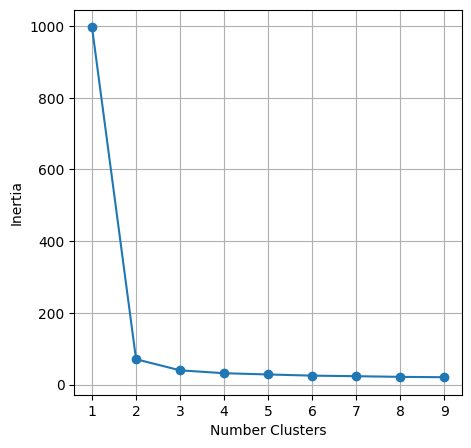

In [297]:
#revisar cuantos clusters crear
#inertia es SSE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
def optimize_k_means(data,max_k):
    means = []
    inertias = []
    for k in range(1,max_k):
        k_means = KMeans(n_clusters=k)
        k_means.fit(data)
        means.append(k)
        inertias.append(k_means.inertia_)

    fig = plt.subplots(figsize=(5,5))
    plt.plot(means,inertias, 'o-')
    plt.xlabel('Number Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

optimize_k_means(scaled_data,10)

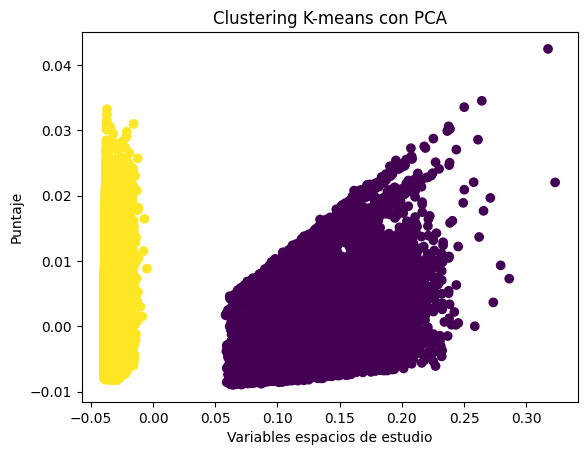

In [298]:
#se hacen dos clusters de kmeans para probar
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=2) #se toma el numero de clusters dependiendo del grafico de codo y se hace el kmeans clustering
kmeans.fit(scaled_data)
labels = kmeans.labels_

y_pca = scaled_data[:, 0]

pca2 = PCA(n_components=2, random_state=0)
x_pca = pca2.fit_transform(scaled_data)

#se visualiza el grafico
plt.scatter(x_pca[:,0], x_pca[:,1], c=labels, cmap='viridis')
plt.title('Clustering K-means con PCA')
plt.xlabel('Variables espacios de estudio')
plt.ylabel('Puntaje')
plt.show()

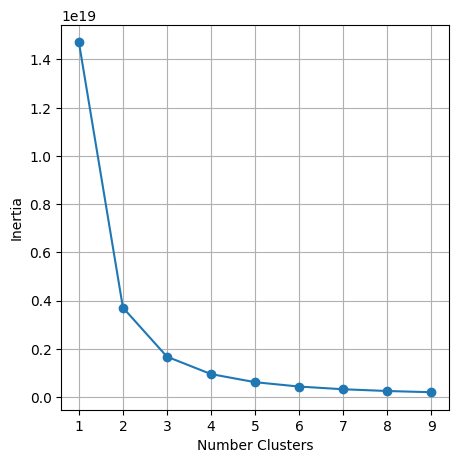

In [299]:
optimize_k_means(merged_new,10)

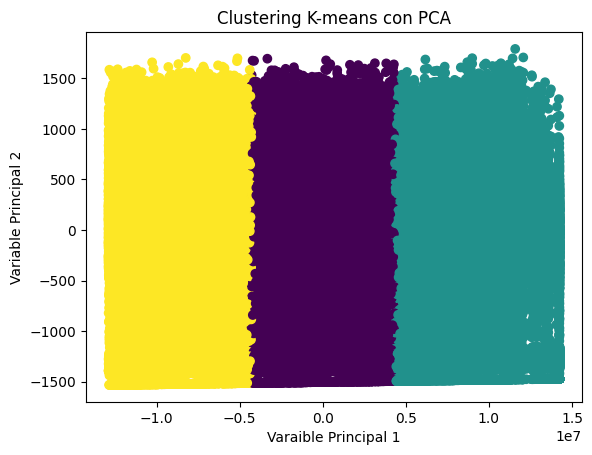

In [300]:

kmeans = KMeans(n_clusters=3) #se toma el numero de clusters dependiendo del grafico de codo y se hace el kmeans clustering
kmeans.fit(merged_new)
labels = kmeans.labels_

pca2 = PCA(n_components=2, random_state=0)
x_pca = pca2.fit_transform(merged_new)

#se visualiza el grafico
plt.scatter(x_pca[:,0], x_pca[:,1], c=labels, cmap='viridis')
plt.title('Clustering K-means con PCA')
plt.xlabel('Varaible Principal 1')
plt.ylabel('Variable Principal 2')
plt.show()

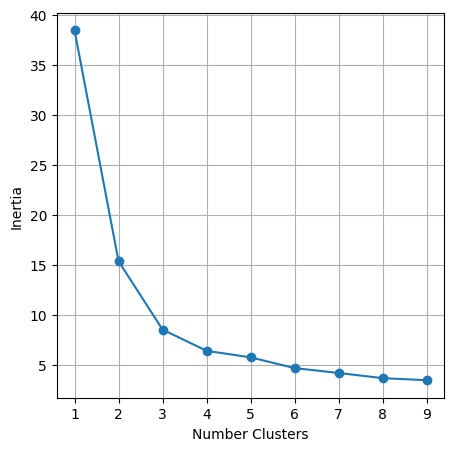

In [301]:
normalizer = Normalizer()
scaled_data = normalizer.fit_transform(merged_new)

optimize_k_means(scaled_data,10)

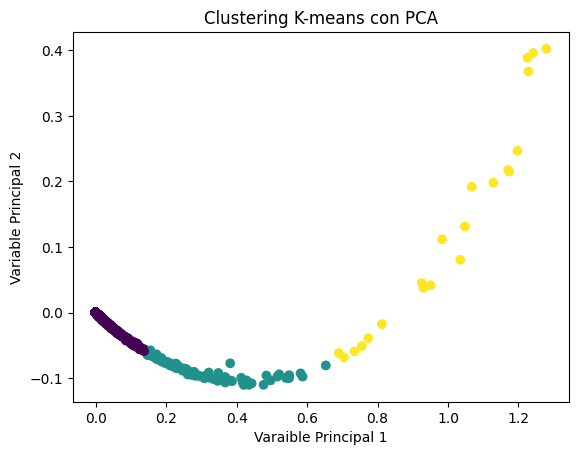

In [302]:
kmeans = KMeans(n_clusters=3) #se toma el numero de clusters dependiendo del grafico de codo y se hace el kmeans clustering
kmeans.fit(scaled_data)
labels = kmeans.labels_

pca2 = PCA(n_components=2, random_state=0)
x_pca = pca2.fit_transform(scaled_data)

#se visualiza el grafico
plt.scatter(x_pca[:,0], x_pca[:,1], c=labels, cmap='viridis')
plt.title('Clustering K-means con PCA')
plt.xlabel('Varaible Principal 1')
plt.ylabel('Variable Principal 2')
plt.show()


In [303]:
merged_new['label'] = labels
cluster0 = merged_new[merged_new['label']==0]
cluster1 = merged_new[merged_new['label']==1]
cluster2 = merged_new[merged_new['label']==2]

for i in range(0,3):
    cluster_i = f"cluster{i}"
    print(f"Filas de cluster {i}: " + str(eval(cluster_i).shape[0]))

Filas de cluster 0: 262542
Filas de cluster 1: 94
Filas de cluster 2: 21


In [304]:
cluster0.describe()

,MRUN,SEXO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,DISPOSITIVO_1,DISPOSITIVO_2,DISPOSITIVO_3,DISPOSITIVO_4,DISPOSITIVO_5,USO_DISPOSITIVO_1,...,MATE2_REG_ACTUAL,HCSOC_REG_ACTUAL,CIEN_REG_ACTUAL,PROMEDIO_CM_MAX,CLEC_MAX,MATE1_MAX,MATE2_MAX,HCSOC_MAX,CIEN_MAX,label
count,2.625420e+05,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,...,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.000000,262542.0
mean,1.289249e+07,1.541251,24.588763,3.083457,0.752074,0.142541,0.917468,0.012760,0.032711,1.642213,...,180.746901,229.551801,298.670948,526.226838,571.183354,491.218742,229.036448,245.486185,312.477021,0.0
std,7.481178e+06,0.498296,39.001224,1.433812,0.431809,0.349605,0.275173,0.112237,0.177879,1.316626,...,223.355824,263.726309,261.884897,228.695879,236.372709,221.183281,233.254106,265.700302,260.429553,0.0
min,4.261000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,6.431500e+06,1.000000,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,483.000000,508.000000,437.000000,0.000000,0.000000,0.000000,0.0
50%,1.286340e+07,2.000000,5.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,417.000000,566.000000,619.000000,507.000000,313.000000,0.000000,424.000000,0.0
75%,1.931241e+07,2.000000,10.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,399.000000,468.000000,501.000000,655.500000,714.000000,601.000000,418.000000,480.000000,503.000000,0.0
max,2.713461e+07,2.000000,99.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.0


In [305]:
cluster1.describe()

,MRUN,SEXO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,DISPOSITIVO_1,DISPOSITIVO_2,DISPOSITIVO_3,DISPOSITIVO_4,DISPOSITIVO_5,USO_DISPOSITIVO_1,...,MATE2_REG_ACTUAL,HCSOC_REG_ACTUAL,CIEN_REG_ACTUAL,PROMEDIO_CM_MAX,CLEC_MAX,MATE1_MAX,MATE2_MAX,HCSOC_MAX,CIEN_MAX,label
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0
mean,7054.659574,1.638298,29.170213,3.095745,0.861702,0.234043,0.925532,0.0,0.021277,1.925532,...,223.191489,272.287234,366.957447,622.510638,671.946809,585.340426,266.638298,280.638298,367.957447,1.0
std,2983.185980,0.483070,41.197567,1.384003,0.347063,0.425669,0.263939,0.0,0.145079,1.246409,...,245.420608,265.297059,257.248590,155.265399,137.665042,166.180790,243.239687,267.954973,257.779264,0.0
min,2458.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,376.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,4536.750000,1.000000,3.000000,3.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,543.125000,582.000000,499.000000,0.000000,0.000000,0.000000,1.0
50%,6440.500000,2.000000,7.000000,3.000000,1.000000,0.000000,1.000000,0.0,0.000000,2.000000,...,0.000000,343.500000,442.000000,612.500000,673.500000,554.000000,358.500000,352.000000,442.000000,1.0
75%,9283.250000,2.000000,76.750000,3.000000,1.000000,0.000000,1.000000,0.0,0.000000,3.000000,...,413.000000,511.000000,529.000000,698.000000,788.000000,688.000000,444.000000,518.500000,529.000000,1.0
max,14134.000000,2.000000,99.000000,9.000000,1.000000,1.000000,1.000000,0.0,1.000000,4.000000,...,843.000000,874.000000,830.000000,956.000000,912.000000,1000.000000,873.000000,874.000000,830.000000,1.0


In [306]:
cluster2.describe()

,MRUN,SEXO,INGRESO_PERCAPITA_GRUPO_FA,RAZON_PRINCIPAL_PAES,DISPOSITIVO_1,DISPOSITIVO_2,DISPOSITIVO_3,DISPOSITIVO_4,DISPOSITIVO_5,USO_DISPOSITIVO_1,...,MATE2_REG_ACTUAL,HCSOC_REG_ACTUAL,CIEN_REG_ACTUAL,PROMEDIO_CM_MAX,CLEC_MAX,MATE1_MAX,MATE2_MAX,HCSOC_MAX,CIEN_MAX,label
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0
mean,1011.285714,1.571429,26.190476,2.761905,0.619048,0.190476,0.904762,0.0,0.047619,1.476190,...,244.333333,217.809524,418.380952,587.833333,629.714286,545.952381,305.619048,280.809524,418.761905,2.0
std,645.134881,0.507093,41.778726,1.445848,0.497613,0.402374,0.300793,0.0,0.218218,1.503963,...,219.592198,270.428478,221.295385,101.135594,140.621529,90.812156,228.514436,263.343999,221.469615,0.0
min,87.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,424.000000,396.000000,402.000000,0.000000,0.000000,0.000000,2.0
25%,579.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,402.000000,514.000000,508.000000,484.000000,0.000000,0.000000,402.000000,2.0
50%,882.000000,2.000000,4.000000,3.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,...,351.000000,0.000000,493.000000,582.500000,663.000000,507.000000,399.000000,391.000000,493.000000,2.0
75%,1564.000000,2.000000,9.000000,3.000000,1.000000,0.000000,1.000000,0.0,0.000000,3.000000,...,459.000000,454.000000,572.000000,671.000000,745.000000,619.000000,477.000000,454.000000,572.000000,2.0
max,2095.000000,2.000000,99.000000,8.000000,1.000000,1.000000,1.000000,0.0,1.000000,4.000000,...,483.000000,782.000000,691.000000,798.000000,853.000000,743.000000,614.000000,782.000000,691.000000,2.0
